## Fitting a Gaussian Process model to a transient class

### Introduction

In this notebook we will demonstrate the basics of fitting a Gaussian Process regression to a collection of supernova (SN) data. This assumes that our data has already been processed and saved using the functionality that exists in this codebase.

### Setup

First let's import our functionality and models. The dependencies from these imports will also initialize the dust maps needed to correct for Milky Way extinction in our photometry:

In [1]:
%load_ext autoreload
%autoreload 2
from caat import SNCollection, GP, GP3D
import numpy as np
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel
import logging

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

Configuration file not found:

    /Users/craigpellegrino/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


### 1. GP fitting in 1 dimension

We will start by introducing GP fitting on a per-filter basis. This is not the full functionality of this module, but is a building block to multi-dimensional fitting.

First, we construct the kernel, initialize the collection of objects to fit, as well as the GP class.

In [2]:
# 1-D GP fit takes kernel and SNCollection
kernel = Matern(length_scale=10, length_scale_bounds=(1e-10, 10.), nu=1.5) + WhiteKernel(1., (1e-10, 10.))
IIb = SNCollection(sntype="SESNe",snsubtype="SNIIb")

gp = GP(sne_collection=IIb, kernel=kernel, filtlist=['g'], phasemin=-20, phasemax=50, log_transform=22)

Next, we produce a train/test split to train the GP, and demonstrate its prediction on the test sample.

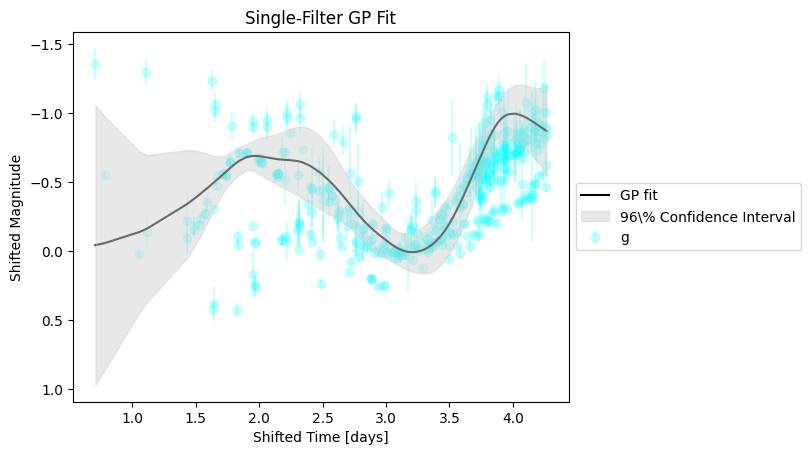

In [3]:
gp.predict(filt='g', test_size=0.9, plot=True)

The fit more or less tracks the evolution in a single band. However, we would like to expand this functionality to fit across wavelengths as well as across phases to produce a continuous spectral energy distribution (SED) "surface" at arbitrary phase and wavelength. 

### 2. Multidimensional GP Fitting

To fit across wavelength and phase simultaneously, we will use the `GP3D` class. The inputs are similar to those of the `GP` class above, with a few modifications.

One nuance is that the `GP3D` class needs both a collection of objects to fit as well as a collection of objects to normalize against. The normalization set of objects is used to calculate residuals of the photometry in the fitting set. This is done to approximate our input data as having a mean of zero--a simplification to the construction of the Gaussian Process.

The `GP3D` class also needs a list of filters, which constrains the input photometry to be fit. Finally, there is an optional `mangle_sed` flag to post-process the GP fit to better match the input photometry

In [7]:
sn_type = SNCollection(sntype="SESNe", snsubtype="SNIIb")

kernel = RBF([np.log(10.0), np.log10(500.0)], (0.1, 3.0))

# The normalization set provides photometry used to construct residuals, which are then fit
#sn_to_normalize = SNCollection(sntype="SNII", snsubtype="SNII")
sn_to_normalize = SNCollection(sntype="SESNe")

filts = ['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'g', 'c', 'V', 'r', 'o', 'i']
phasemin = -20
phasemax = 50
log_transform = 22
mangle_sed = True

gp = GP3D(
    sn_type, 
    kernel, 
    filts,
    phasemin, 
    phasemax,
    set_to_normalize=sn_to_normalize,
    log_transform=log_transform,
    mangle_sed=mangle_sed
)

After initializing the class, the first step to running the GP is to optimize its hyperparameters. This is done by fitting the residuals (after subtracting off the "average" behavior of the normalization set of objects) of the photometry of each object in the fitting sample. This will return the hyperparameters for each fit, which we optimize by taking the median of:

In [8]:
kernel_parameters = gp.optimize_hyperparams(subtract_polynomial=True)

# Let's look at the kernel hyperparameters
optimized_kernel_hyperparams = np.asarray([np.median([k[i] for k in kernel_parameters]) for i in range(len(kernel_parameters[0]))])
print(np.exp(optimized_kernel_hyperparams))

[2.74472347 0.97940864]


The `optimize_hyperparameters` method fixes the length scale of the kernel to the median of the optimized values.

Now let's fit each SN residual light curve with the same hyperparameters. This time, we'll plot each fit:

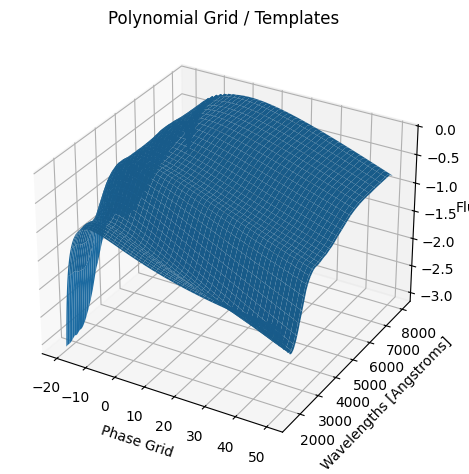

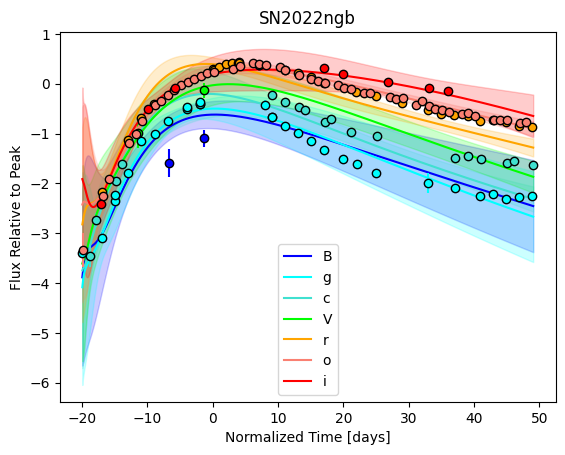

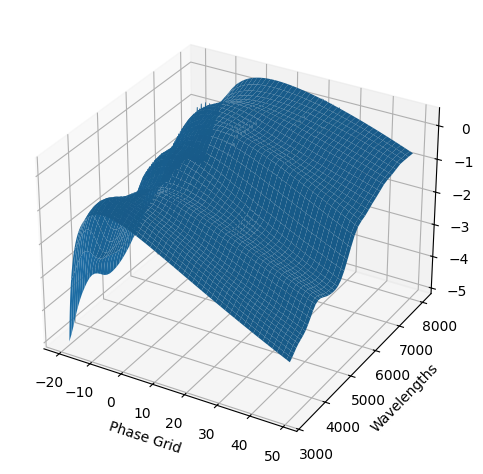

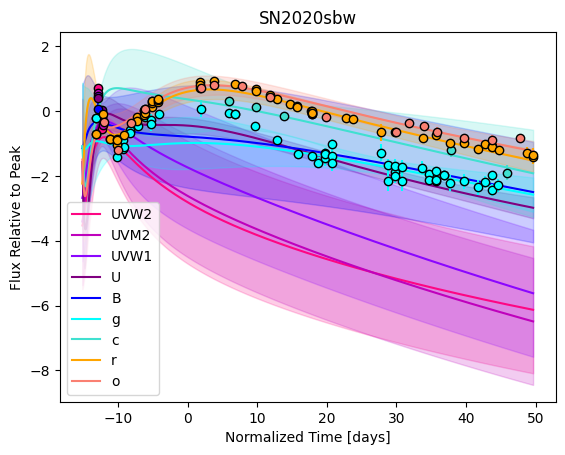

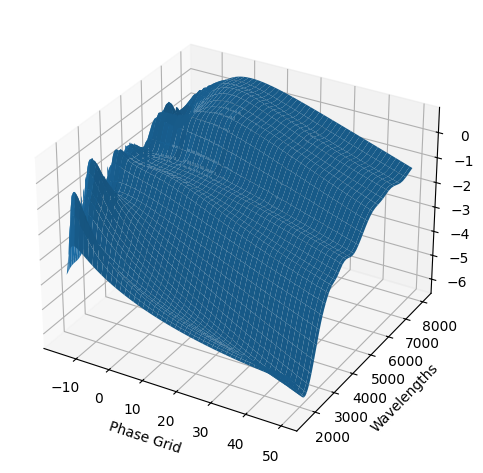

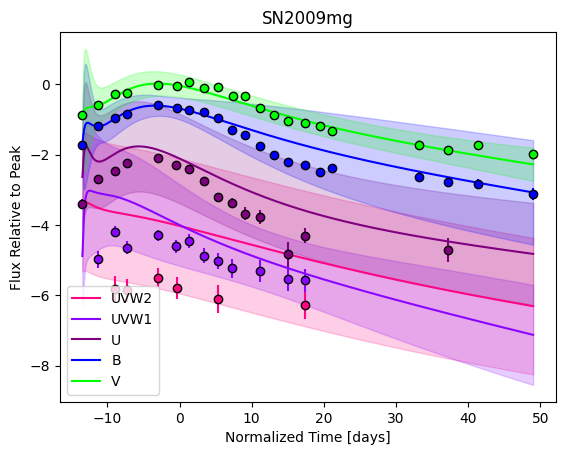

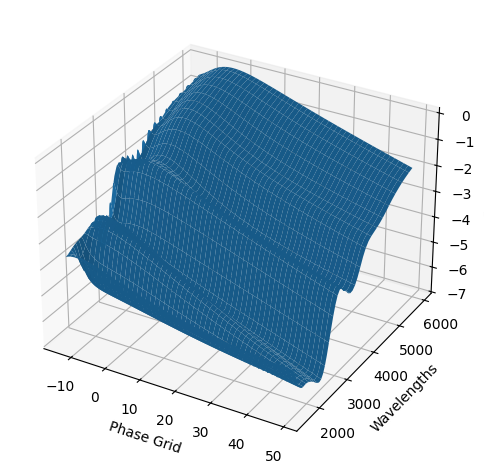

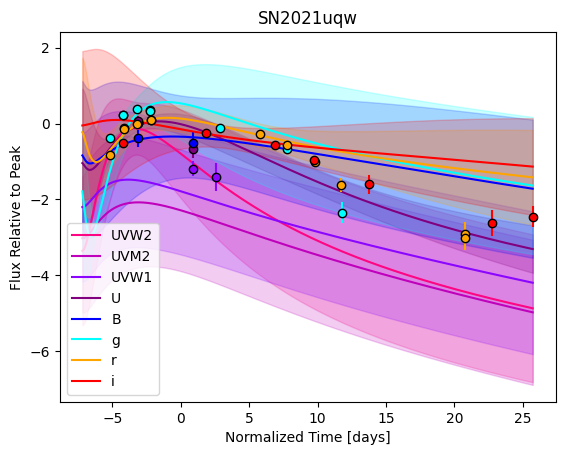

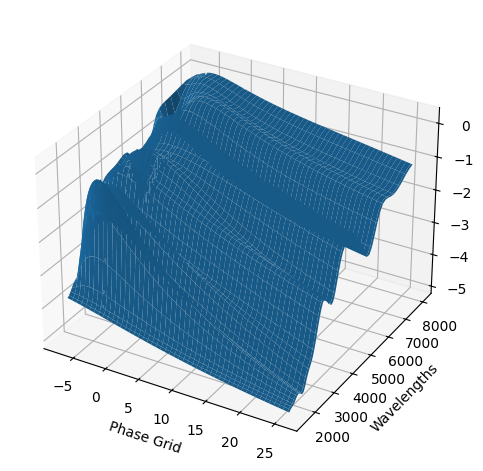

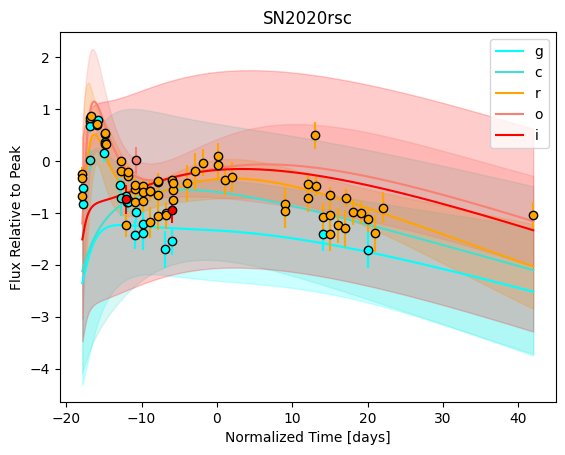

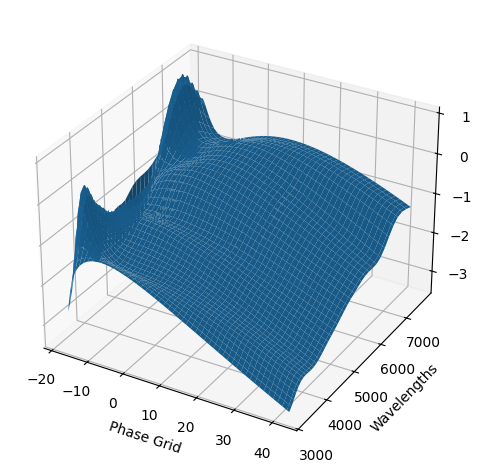

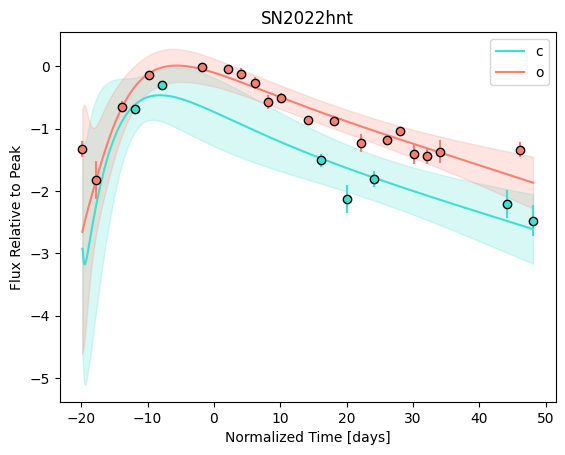

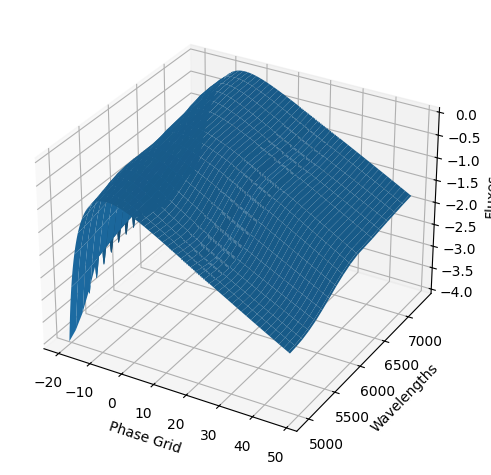

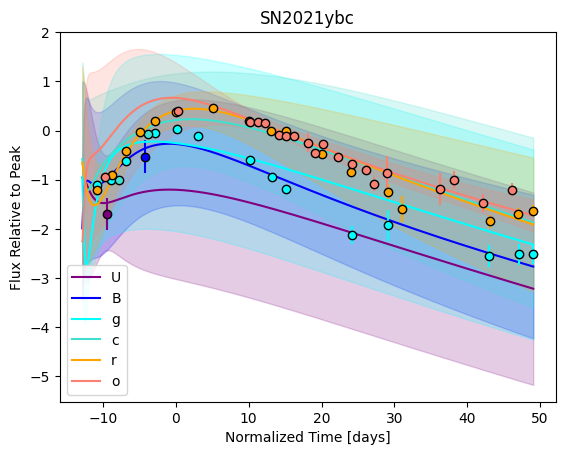

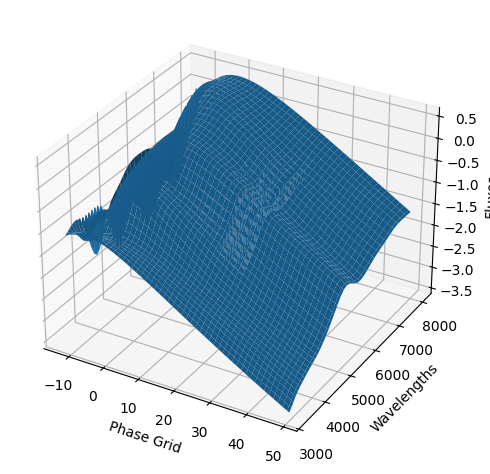

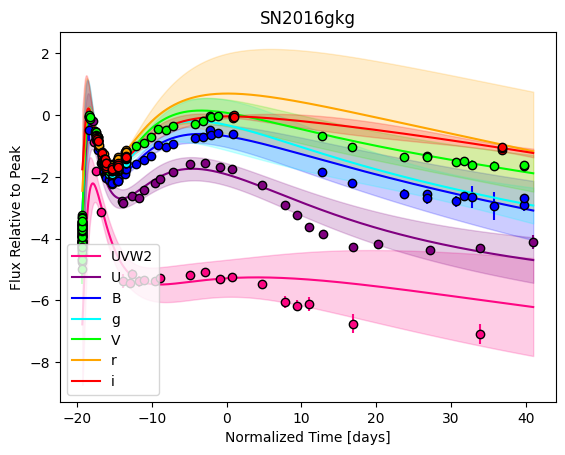

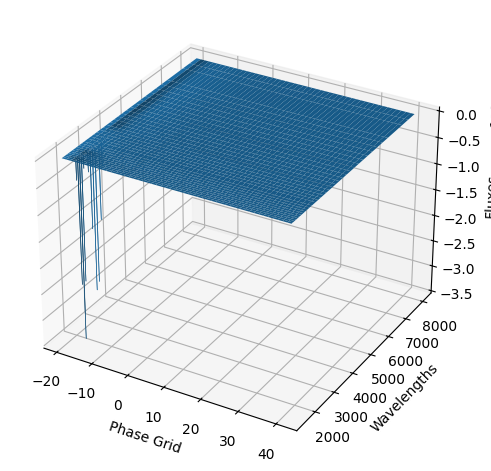

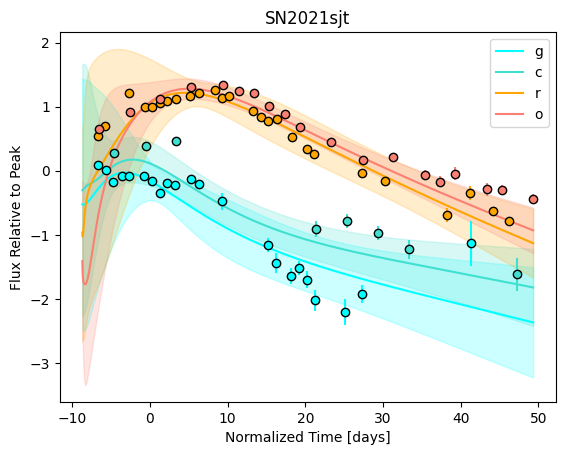

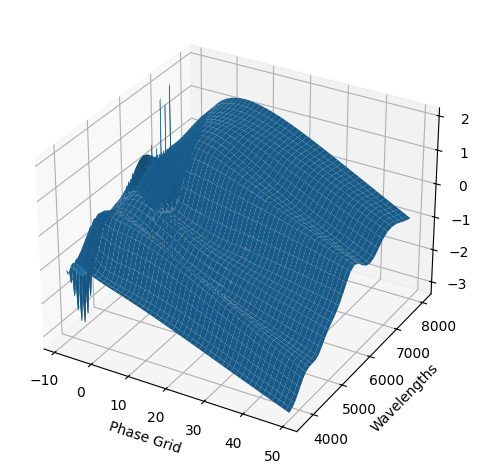

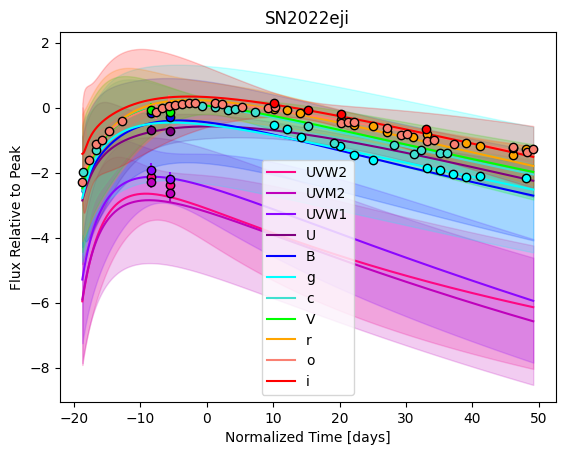

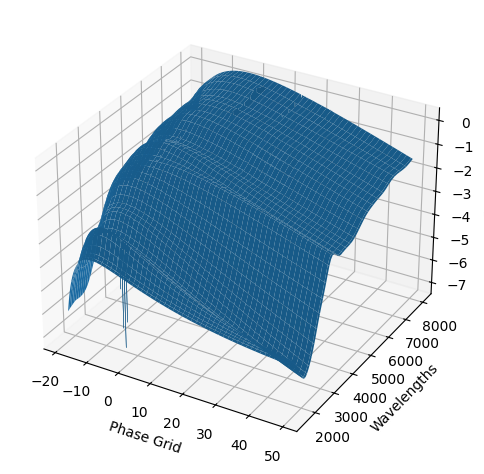

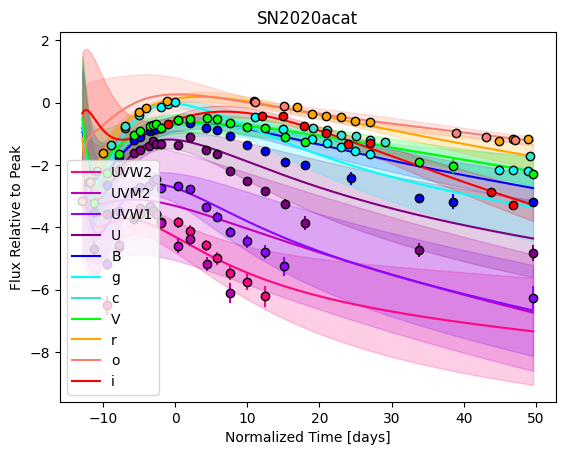

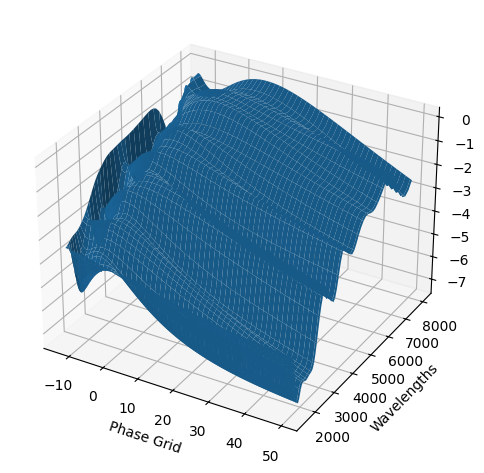

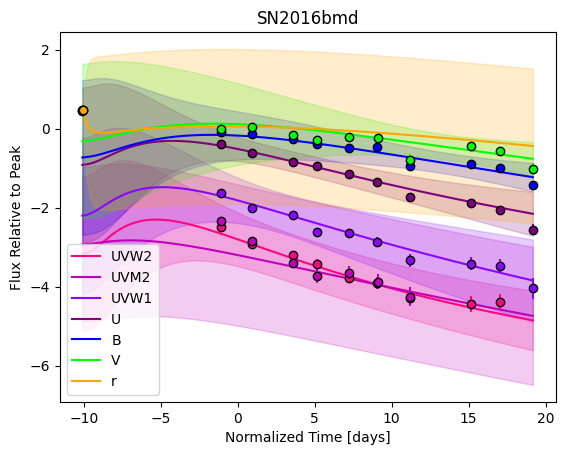

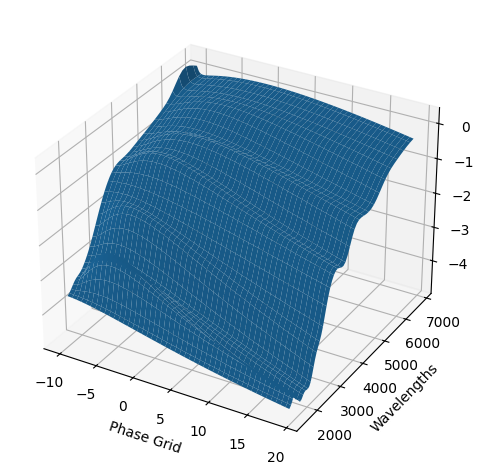

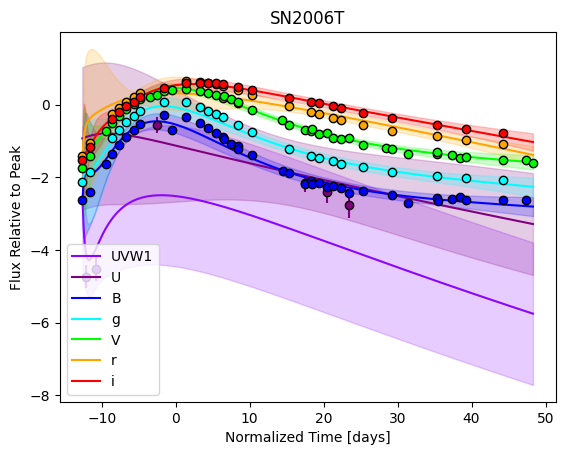

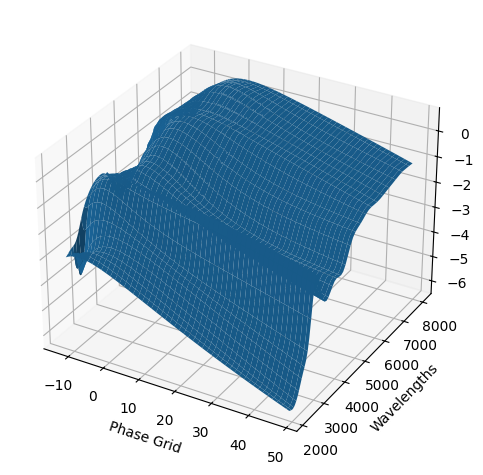

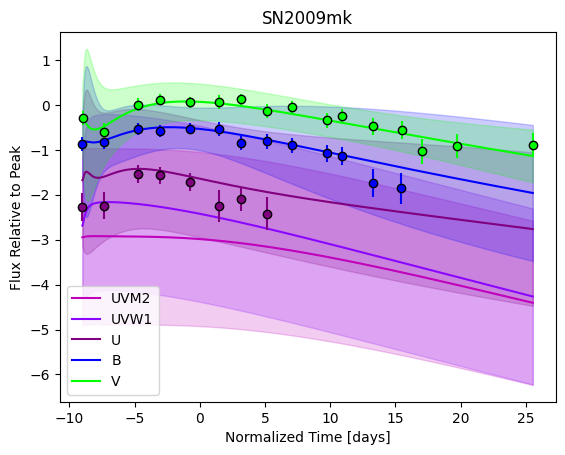

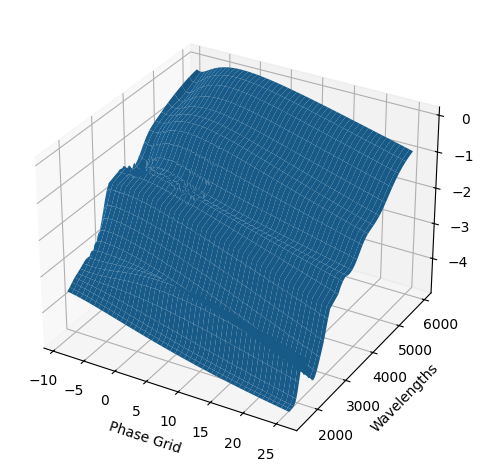

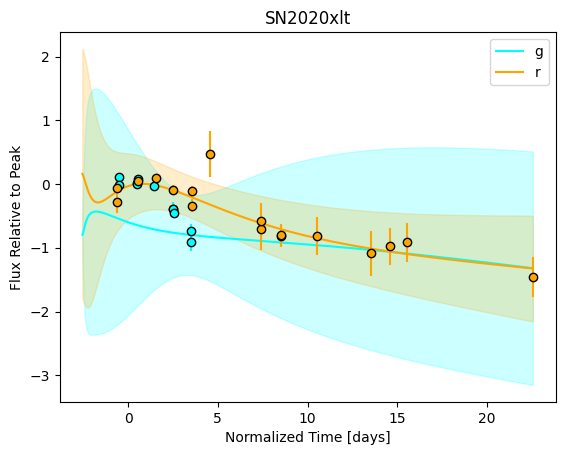

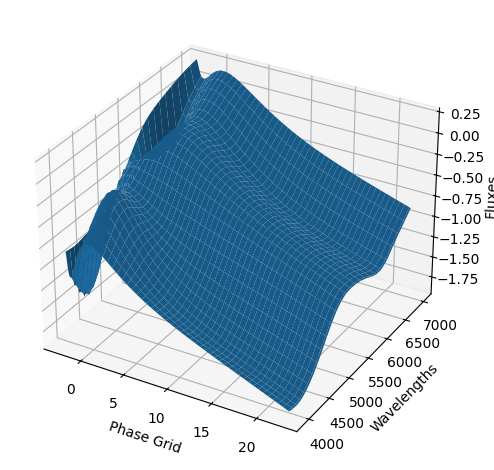

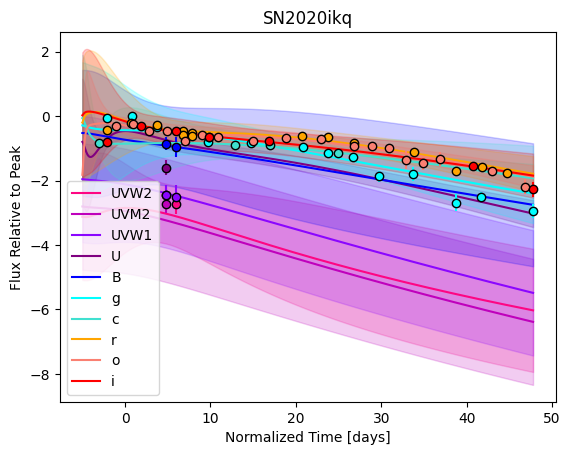

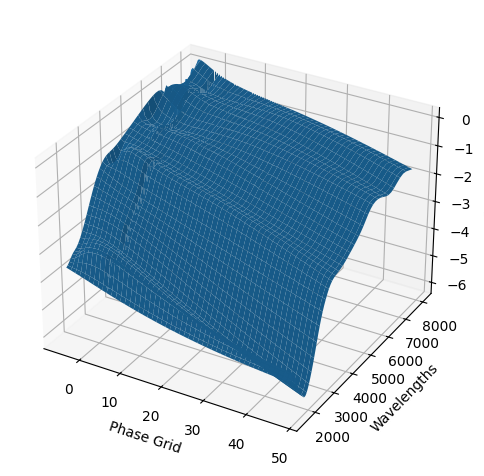

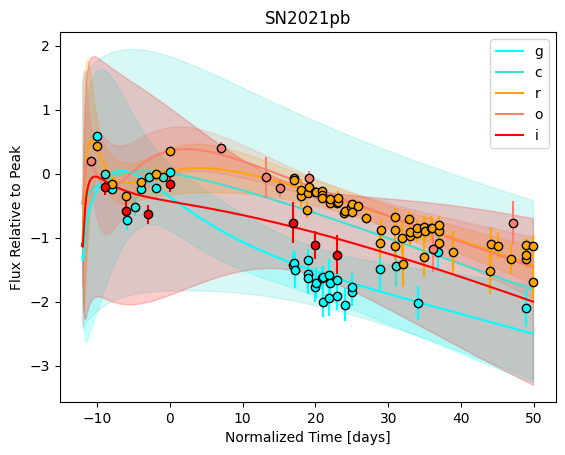

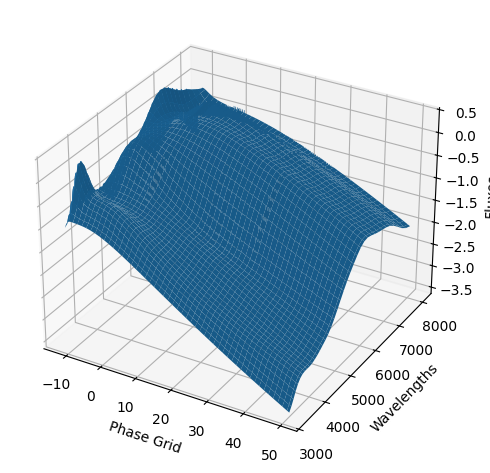

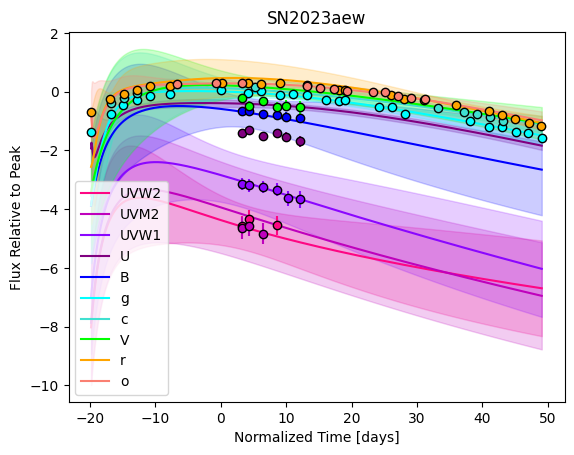

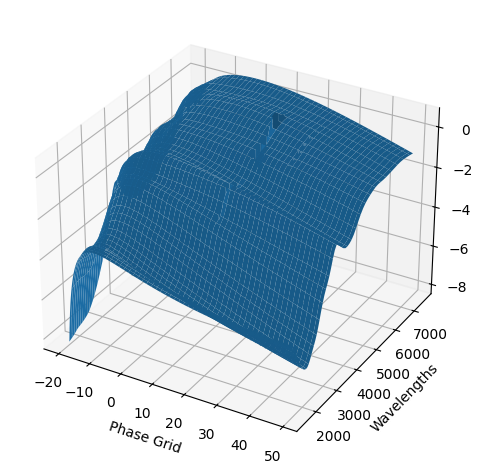

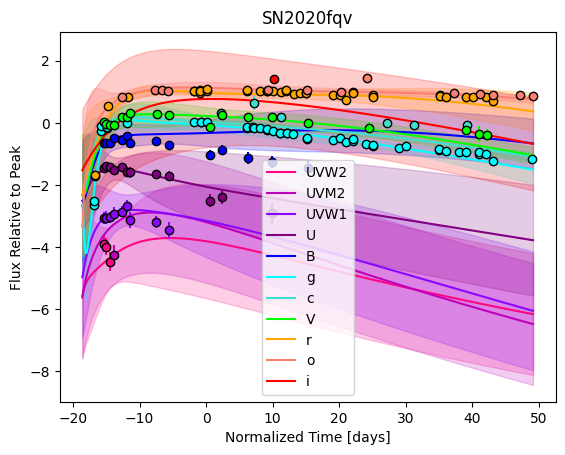

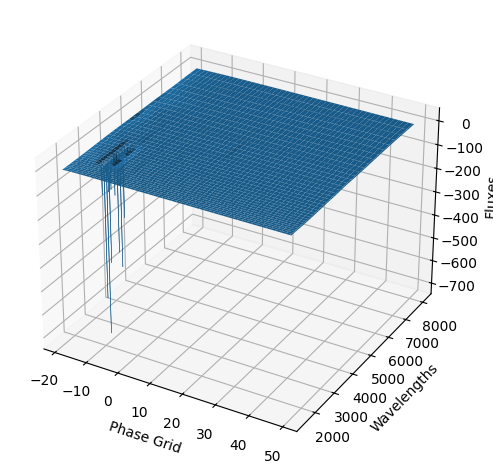

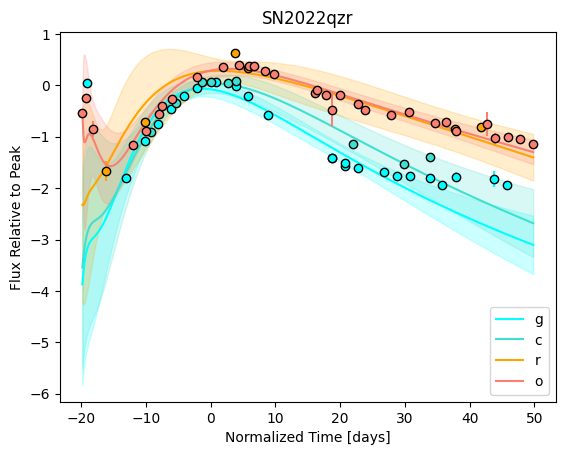

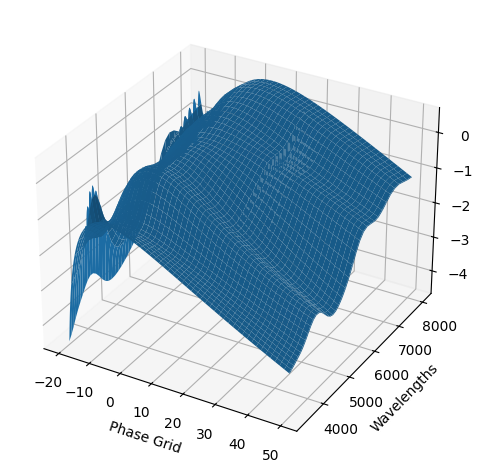

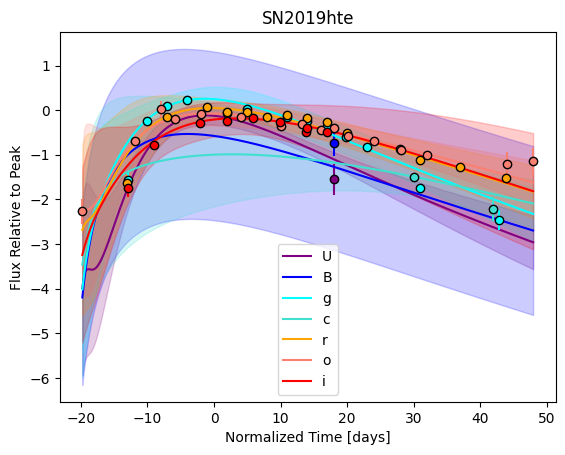

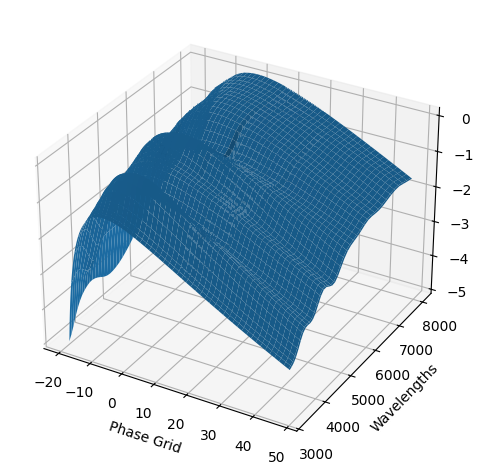

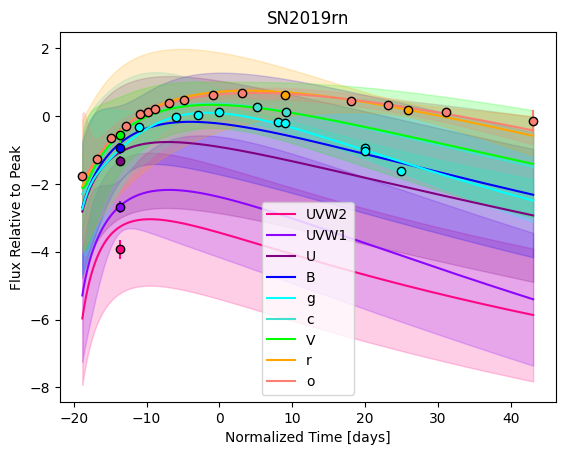

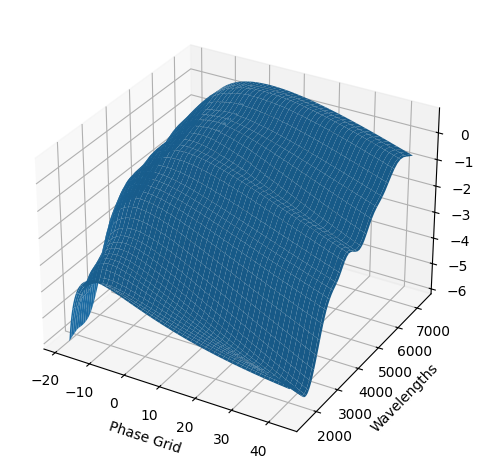

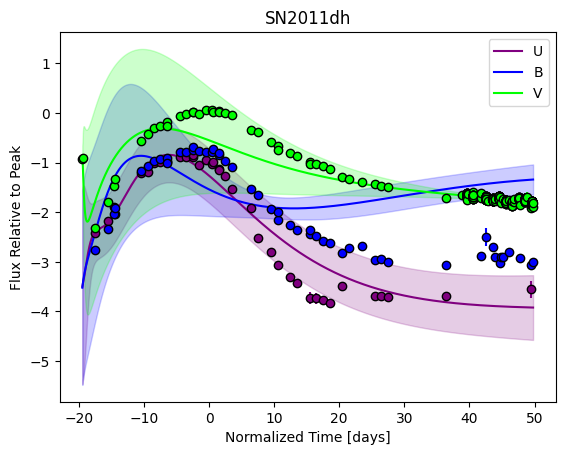

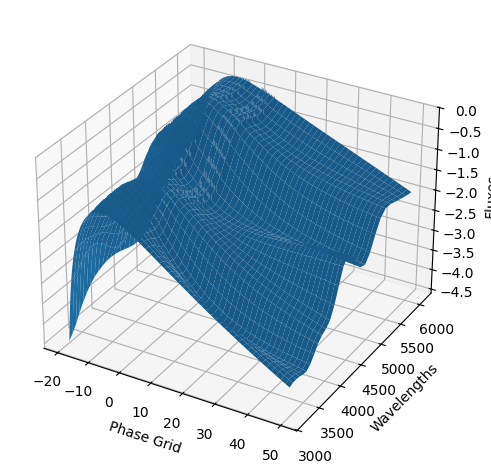

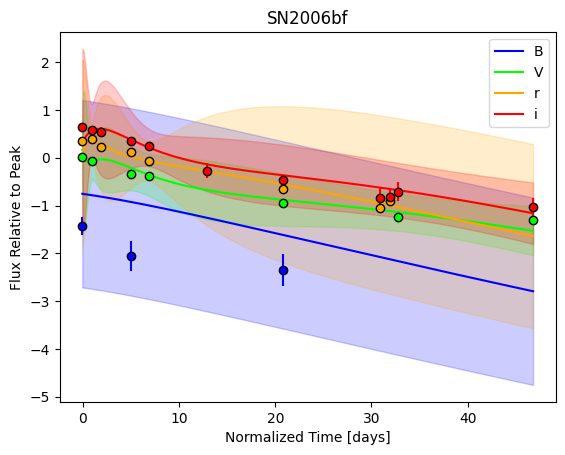

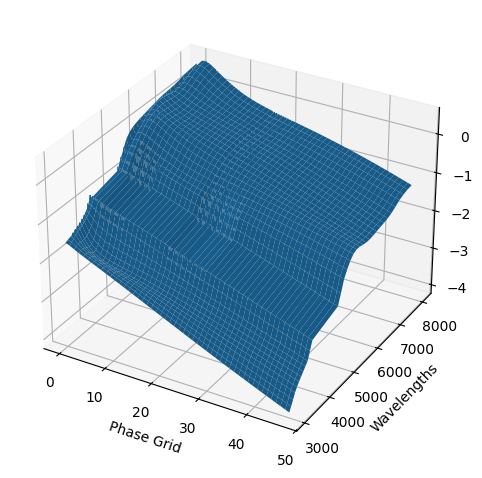

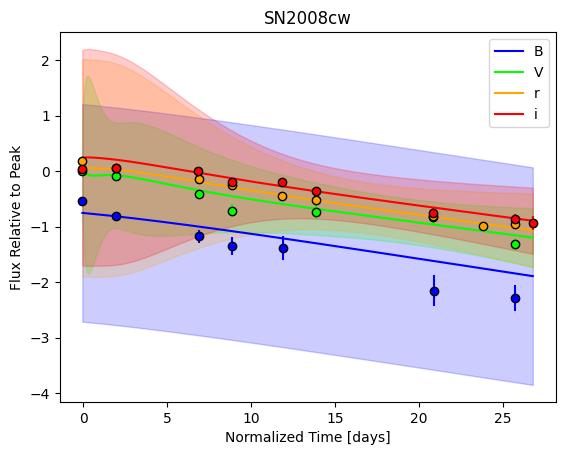

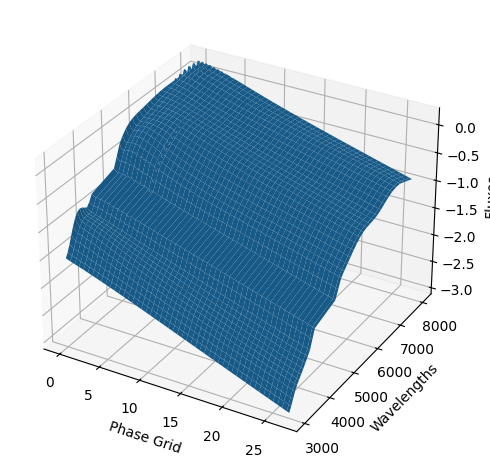

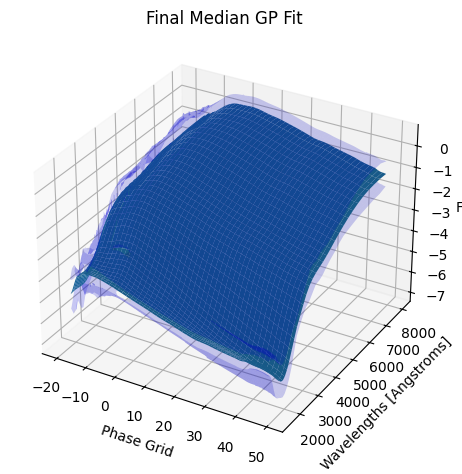

In [9]:
%matplotlib inline
gp.predict(
    plot=True,
    subtract_polynomial=True,
)

For each SN in our fitting sample, two plots are shown: the first is the GP fit to each filter for that SN, and the second is the full predicted 3D SED surface across the phases and wavelengths covered by that SN's photometry. The final plot shown is the full 3D GP surface created by averaging each individual predicted SED surface over the full range of phases and wavelengths.

### Next steps:

The output of the `predict` method is a `SNModel` object, which can be saved, loaded, and manipulated to produce predicted light curves, spectra, photometry, or fits to new objects. These features will be covered in the `using_gp_models` notebook.